In [16]:
import pandas as pd
import math
import keras
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import mean_squared_error
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas
plt.rcParams["figure.figsize"] = (20,10)

In [21]:
import os
print(os.getcwd())

C:\Users\Amin y Lubna\Documents\GitHub\Intelligent-Solar-Energy-Manager\Machine Learning\Solar Energy


In [17]:
rows_to_skip=16
rows_to_read=8760
X_data=pd.read_csv('TMYPalma.csv',skiprows=rows_to_skip,nrows=rows_to_read,parse_dates=['time(UTC)'],index_col='time(UTC)')
X_data.index=pd.to_datetime(X_data.index, format='%Y%m%d:%H%M')
X_data=X_data.drop(columns=['Gb(n)', 'Gd(h)','IR(h)'])
X_data=X_data.rename(columns={"T2m":"temp","RH":"humidity","G(h)":"irradiance","WS10m":"speed","WD10m":"deg","SP":"pressure"})
X_data['Hour']=X_data.index.hour
X_data['Month']=X_data.index.month
X_data.index = X_data.index.map(lambda x: x.replace(year=2014))

In [18]:
def split_data(df,train_size):
    train_days=math.floor(len(df)*train_size/24)
    train_data,test_data=df.iloc[0:train_days*24],df.iloc[train_days*24:len(df)]
    return train_data,test_data

In [19]:
def create_trainable_dataset(dataframe,n_inputs,n_outputs):
    X,Y=list(),list()
    for i in range(len(dataframe)-n_inputs-n_outputs+1):
        X.append(dataframe.iloc[i:(i+n_inputs), :])
        Y.append(dataframe.iloc[i + n_inputs:i + n_inputs + n_outputs, 2])
    return np.array(X), np.array(Y)

In [20]:
def scale_data(train_data,test_data):
    f_columns=['temp','humidity','speed','deg','pressure','Hour','Month']
    f_transformer=MinMaxScaler()
    t_transformer=MinMaxScaler()
    f_transformer = f_transformer.fit(train_data[f_columns].to_numpy())
    t_transformer = t_transformer.fit(train_data[['irradiance']])
    train_data.loc[:, f_columns] = f_transformer.transform(train_data[f_columns].to_numpy())
    train_data['irradiance'] = t_transformer.transform(train_data[['irradiance']])
    test_data.loc[:, f_columns] = f_transformer.transform(test_data[f_columns].to_numpy())
    test_data['irradiance'] = t_transformer.transform(test_data[['irradiance']])
    return f_transformer,t_transformer,train_data,test_data

In [15]:
n_input=240#10 day 24x10=240 hours
n_output=24#1 day 24x10=240 hours
train_size=0.8
train_data,test_data=split_data(X_data,train_size)
f_trans,t_trans,s_train_data,s_test_data=scale_data(train_data,test_data)
X_train,Y_train=create_trainable_dataset(s_train_data,n_input,n_output)
X_test,Y_test=create_trainable_dataset(s_test_data,n_input,n_output)

C:\Users\Amin y Lubna\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-14-c6e5b8591122>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['irradiance'] = t_transformer.transform(train_data[['irradiance']])
C:\Users\Amin y Lubna\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [56]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(Y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [ ]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=1
        )
tuner.search(
        x=X_train,
        y=Y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_test,Y_test),
)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
input_unit        |64                |?                 
n_layers          |4                 |?                 
lstm_0_units      |288               |?                 
layer_2_neurons   |128               |?                 
Dropout_rate      |0.3               |?                 
dense_activation  |sigmoid           |?                 

Epoch 1/20
53/53 [==============================] - 192s 3s/step - loss: 0.1204 - mse: 0.1204 - val_loss: 0.0389 - val_mse: 0.0389
Epoch 2/20
53/53 [==============================] - 184s 3s/step - loss: 0.0943 - mse: 0.0943 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 3/20
53/53 [==============================] - 162s 3s/step - loss: 0.0943 - mse: 0.0943 - val_loss: 0.0421 - val_mse: 0.0421
Epoch 4/20
53/53 [==============================] - 160s 3s/step - loss: 0.0936 - mse: 0.0936 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 5/20
53/53 [==============================]

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]


In [46]:
Y_pred=best_model.predict(X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1])))

In [47]:
print(Y_pred)

[[0.166987]]


<function matplotlib.pyplot.legend(*args, **kwargs)>

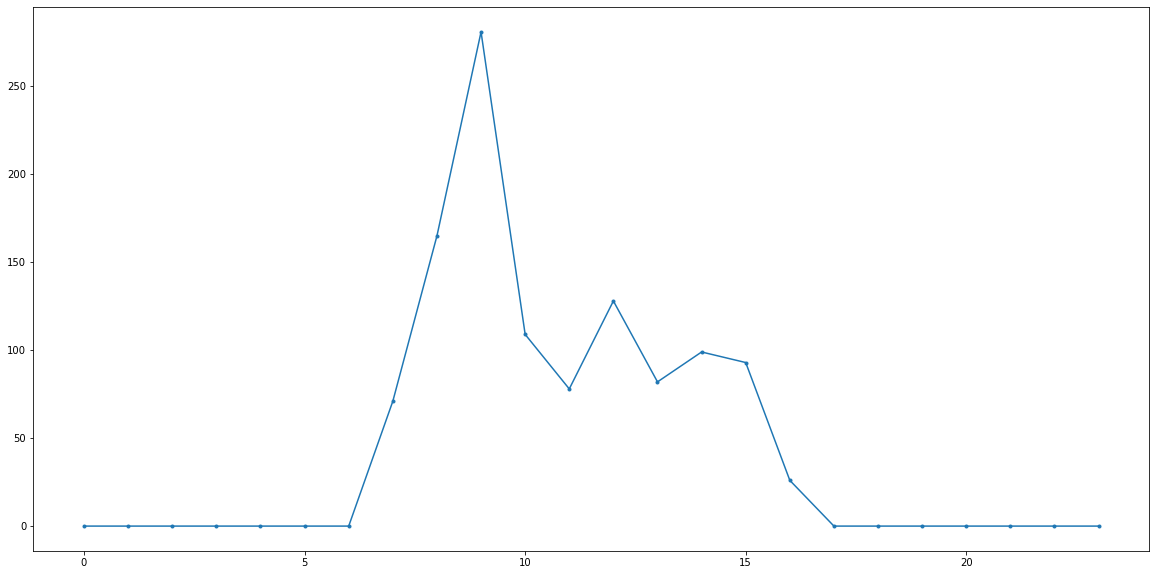

In [45]:
Y_pred_inv=t_trans.inverse_transform(Y_pred.reshape(1,-1))
Y_test_inv=t_trans.inverse_transform(Y_test[0].reshape(1,-1))
#Y_test_inv=t_transformert.inverse_transform(Y_test)
plt.plot(Y_test_inv.flatten(),marker='.',label='Reales')
#plt.plot(Y_pred_inv.flatten(),'r',label='Prediccion')
plt.legend

# Saving model
Once the model has been trained has to be saved it, to use it later with streaming data in the Raspberry Pi

In [27]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [28]:
# load json and create model
json_file = open('C:\\Users\\Amin y Lubna\\Desktop\\Escritorio Virtual\\Carrera Amin\\2.TFG\\Modelo NN y Scaler\\model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:\\Users\\Amin y Lubna\\Desktop\\Escritorio Virtual\\Carrera Amin\\2.TFG\Modelo NN y Scaler\\model.h5")

In [29]:
dump(t_trans, open('target_scaler.pkl', 'wb'))
dump(f_trans, open('feature_scaler.pkl', 'wb'))

In [30]:
scaler = load(open('C:\\Users\\Amin y Lubna\\Desktop\\Escritorio Virtual\\Carrera Amin\\2.TFG\Modelo NN y Scaler\\target_scaler.pkl', 'rb'))

In [45]:
scaler = load(open('C:\\Users\\Amin y Lubna\\Desktop\\Escritorio Virtual\\Carrera Amin\\2.TFG\Modelo NN y Scaler\\feature_scaler.pkl', 'rb'))
    